## Project Title:
Telecom Customer Churn prediction model



## Introduction
This project aims to assist a telecom company in understanding their data and predicting customer churn. The company has provided access to three different datasets: the first dataset with 3000 records stored in a remote Microsoft SQL Server database, the second dataset with 2000 records stored on OneDrive, and the third dataset hosted on a GitHub repository.

## Objectives
Understand the data: Our first objective is to provide insights into the telecom company's data, including customer demographics, services availed, and payment details. This understanding will enable the company to make informed business decisions.

Find the lifetime value of each customer: By analyzing the data, we aim to identify factors that influence the rate at which customers churn. Understanding customer behavior and identifying key predictors will help the telecom company estimate the lifetime value of each customer.

Predict customer churn: The primary objective is to develop a predictive model that accurately determines whether a customer is likely to churn or not. We will employ machine learning algorithms such as logistic regression, decision trees, support vector machines, random forest, etc., to build a model that effectively predicts customer churn.

## Methodology
To achieve our objectives, we will follow the CRISP-DM framework, which consists of the following steps:

Data exploration: We will thoroughly explore the datasets to gain insights into the available variables, their distributions, and relationships. This step will provide us with an initial understanding of the data and help identify any data quality issues.

Missing value computations: We will identify missing values in the datasets and decide on an appropriate strategy for handling them. This may involve imputing missing values or removing data points with missing values.

Feature engineering: We will perform feature engineering to transform and create new variables that can potentially improve the predictive power of our models. This step may include encoding categorical variables, scaling numerical variables, or creating interaction terms.

Model development: We will utilize various machine learning algorithms such as logistic regression, decision trees, support vector machines, random forest, etc., to develop predictive models for customer churn. We will train the models on a subset of the data and evaluate their performance using appropriate metrics.

Model evaluation and interpretation: We will evaluate the trained models using evaluation metrics such as accuracy, precision, recall, and F1-score. Additionally, we will interpret the models to understand the factors driving customer churn and their relative importance.

Model optimization and hyperparameter tuning: We will fine-tune the models by optimizing their hyperparameters to improve their performance. This step may involve techniques like grid search or random search to find the optimal combination of hyperparameters.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.

## Hypothesis:

Null hypothesis : There's a significant difference in the average monthly average between churners and non-churners.

Alternative hypothesis: There is no significant difference in the average monthly average between churners and non-churners.

In [1341]:
# %pip install pyodbc
# %pip install python-dotenv 
# %pip install openpyxl
# %pip install imbalanced-learn

In [1342]:
# Database connections

import pyodbc 
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import warnings 
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
pd.set_option('display.max_columns', None)
import openpyxl
import numpy as np

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots

# EDA (pandas-profiling, etc. )
from statsmodels.genmod.families import Binomial
from scipy.stats import pointbiserialr
import scipy.stats as stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Other packages
import os, pickle

## Data Loading
Loading first data from SQL

In [1343]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [1344]:
#creating a connection sring to the SQL  database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [1345]:
#creating a connection
connection = pyodbc.connect(connection_string)

In [1346]:
# Read the excel file into a pandas dataframe
query = "Select * from dbo.LP2_Telco_churn_first_3000"
data1 = pd.read_sql(query, connection)

In [1347]:
# the first five rows of the first dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [1348]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [1349]:
data1.to_csv('Data1.csv', index=False)


In [1350]:
#loading the second data set from GitHub repository
url = 'https://raw.github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'
download = requests.get(url).content
data2 = pd.read_csv(io.StringIO(download.decode('utf-8')))
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [1351]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [1352]:
data2.to_csv('Data2.csv', index=False)

## Loading data three from onedrive

In [1353]:
data3 = pd.read_excel('C:/Users/KEMUNTO/Downloads/Telco-churn-last-2000 (1).xlsx')
data3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## Clean First Dataset

In [1354]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [1355]:
# Deleting Customer ID column

del data1["customerID"]

In [1356]:

# convert bool columns to object Dtypes

bool_to_obj = {'Partner': object,
               'SeniorCitizen': object,
               'Dependents': object, 
               'PhoneService': object,
               'PaperlessBilling': object}

data = data1.astype(bool_to_obj)

In [1357]:
# Replace True and False values with Yes and No in Object columns

replace_values = {True: 'Yes', False: 'No'}

# Use replace() method
data1['Partner'] = data1['Partner'].replace(replace_values)
data1['SeniorCitizen'] = data1['SeniorCitizen'].replace(replace_values)
data1['Dependents'] = data1['Dependents'].replace(replace_values)
data1['PhoneService'] = data1['PhoneService'].replace(replace_values)
data1['MultipleLines'] = data1['MultipleLines'].replace(replace_values)
data1['OnlineSecurity'] = data1['OnlineSecurity'].replace(replace_values)
data1['OnlineBackup'] = data1['OnlineBackup'].replace(replace_values)
data1['DeviceProtection'] = data1['DeviceProtection'].replace(replace_values)
data1['TechSupport'] = data1['TechSupport'].replace(replace_values)
data1['StreamingTV'] = data1['StreamingTV'].replace(replace_values)
data1['StreamingMovies'] = data1['StreamingMovies'].replace(replace_values)
data1['PaperlessBilling'] = data1['PaperlessBilling'].replace(replace_values)
data1['Churn'] = data1['Churn'].replace(replace_values)

In [1358]:
# View unique values in target column (Churn)

data1['Churn'].unique()

array(['No', 'Yes', None], dtype=object)

In [1359]:
# check the missing values in target column (Churn)

data1['Churn'].isna().sum()

1

In [1360]:
# Drop missing value in the Churn column

data1.dropna(subset='Churn', inplace=True)

In [1361]:
# view all missing values in first dataset

data1.isnull().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 0
dtype: int64

In [1362]:
# view the missing values in TotalCharges column
data1[np.isnan(data1['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,None,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.549999,NaN,No
753,Male,No,No,Yes,0,Yes,No,No,None,None,None,None,None,None,Two year,No,Mailed check,20.250000,NaN,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.849998,NaN,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,None,None,None,None,None,None,Two year,No,Mailed check,25.750000,NaN,No
1340,Female,No,Yes,Yes,0,No,None,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.049999,NaN,No


 missing values in TotalCharges have a tenure of 0, even though there are values in the MonthlyCharges column. We can simply drop those rows to avoid confusion.

In [1363]:
# Drop rows where tenure = 0
data1.drop(labels=data1[data1['tenure'] == 0].index, axis=0, inplace=True)

In [1364]:
# replace the remaining missing values with the mode of their respective columns

columns_to_replace = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
           'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies']

for column in columns_to_replace:
    data1[column].fillna(data1[column].mode()[0], inplace=True)

In [1365]:
# Reset index after dropping rows
data1.reset_index(drop=True, inplace=True)

In [1366]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994 entries, 0 to 2993
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2994 non-null   object 
 1   SeniorCitizen     2994 non-null   object 
 2   Partner           2994 non-null   object 
 3   Dependents        2994 non-null   object 
 4   tenure            2994 non-null   int64  
 5   PhoneService      2994 non-null   object 
 6   MultipleLines     2994 non-null   object 
 7   InternetService   2994 non-null   object 
 8   OnlineSecurity    2994 non-null   object 
 9   OnlineBackup      2994 non-null   object 
 10  DeviceProtection  2994 non-null   object 
 11  TechSupport       2994 non-null   object 
 12  StreamingTV       2994 non-null   object 
 13  StreamingMovies   2994 non-null   object 
 14  Contract          2994 non-null   object 
 15  PaperlessBilling  2994 non-null   object 
 16  PaymentMethod     2994 non-null   object 


## Clean second dataset

In [1367]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [1368]:
# Drop Customer ID column
data2.drop(columns='customerID', inplace=True)

In [1369]:
# change Dtype of TotalCharges column from object to numeric
data2['TotalCharges'] = pd.to_numeric(data2['TotalCharges'], errors='coerce')

In [1370]:
# merge the test datasets
training_data= pd.concat([data1, data2], ignore_index=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5037 entries, 0 to 5036
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5037 non-null   object 
 1   SeniorCitizen     5037 non-null   object 
 2   Partner           5037 non-null   object 
 3   Dependents        5037 non-null   object 
 4   tenure            5037 non-null   int64  
 5   PhoneService      5037 non-null   object 
 6   MultipleLines     5037 non-null   object 
 7   InternetService   5037 non-null   object 
 8   OnlineSecurity    5037 non-null   object 
 9   OnlineBackup      5037 non-null   object 
 10  DeviceProtection  5037 non-null   object 
 11  TechSupport       5037 non-null   object 
 12  StreamingTV       5037 non-null   object 
 13  StreamingMovies   5037 non-null   object 
 14  Contract          5037 non-null   object 
 15  PaperlessBilling  5037 non-null   object 
 16  PaymentMethod     5037 non-null   object 


There are some missing values in the TotalCharges column,therefore Let us delete the rows with a tenure of 0

In [1371]:
# view Missing Values in TotalCharges column
training_data[np.isnan(training_data['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3212,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
4664,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
4748,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [1372]:
# Drop rows where tenure = 0
training_data.drop(labels=training_data[training_data['tenure'] == 0].index, axis=0, inplace=True)

In [1373]:
# checking all categorical values
training_data.describe(include=['object']).T

,count,unique,top,freq
gender,5034,2,Male,2554
SeniorCitizen,5034,4,No,2519
Partner,5034,2,No,2583
Dependents,5034,2,No,3481
PhoneService,5034,2,Yes,4547
MultipleLines,5034,3,No,2688
InternetService,5034,3,Fiber optic,2247
OnlineSecurity,5034,3,No,3155
OnlineBackup,5034,3,No,2879
DeviceProtection,5034,3,No,2867


In [1374]:
#Seniorcitizen column has more unique values than expected
training_data['SeniorCitizen'].value_counts()

SeniorCitizen
No     2519
0      1696
Yes     475
1       344
Name: count, dtype: int64

In [1375]:
# Replace 'No' values with 0 and 'Yes' values with 1
training_data['SeniorCitizen'] = training_data['SeniorCitizen'].replace({'No': 0, 'Yes': 1})

In [1376]:
training_data['SeniorCitizen'] = training_data['SeniorCitizen'].astype('object')

In [1377]:
# checking for duplicates
print('Known observations: {}\nUnique observations: {}'.format(len(training_data.index),len(training_data.drop_duplicates().index)))
print("**No duplicates Found!**")

Known observations: 5034
Unique observations: 5024
**No duplicates Found!**


In [1378]:
# view unique values of each column
for column in training_data.columns:
    print('Column: {} - Unique Values: {}'.format(column, training_data[column].unique()))

Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No' 'Yes' 'No phone service']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSupport - Unique Values: ['No' 'Yes' 'No internet service']
Column: StreamingTV - Unique Values: ['No' 'Yes' 'No internet service']

In [1379]:
#summary statistic description
training_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,5034.000000,5034.000000,5034.000000
mean,32.620580,65.107251,2300.954758
std,24.511015,30.068019,2268.346402
min,1.000000,18.400000,18.799999
25%,9.000000,35.799999,417.662498
50%,29.000000,70.599998,1401.000000
75%,56.000000,90.050003,3860.599976
max,72.000000,118.650002,8670.100000


tenure


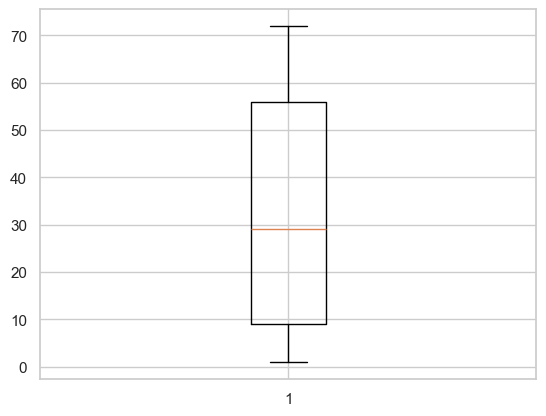

MonthlyCharges


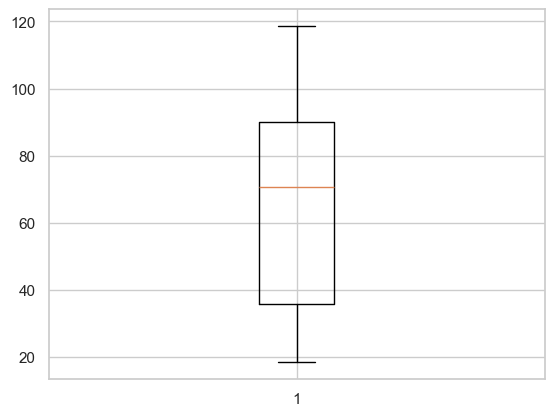

TotalCharges


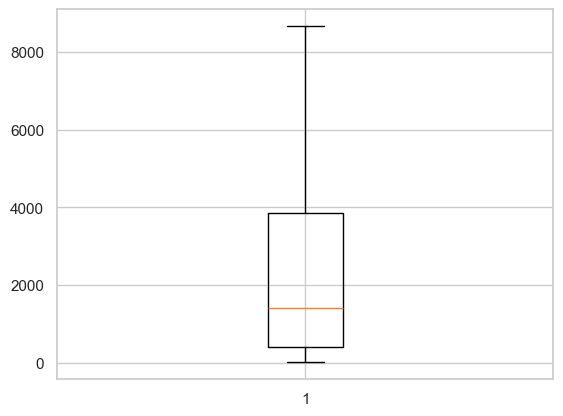

In [1380]:
# Check for outliers in the numerical variables
# Use boxplot
for col in ['tenure','MonthlyCharges','TotalCharges']:
    print(col)
    plt.boxplot(training_data[col])
    plt.show()

## Saving the training dataset

In [1381]:
training_data.reset_index(drop=True, inplace=True)

In [1382]:
# save to csv

training_data.to_csv('Train_Data.csv', index=False)

## Clean test data

In [1383]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [1384]:
# Drop Customer ID column
data3.drop(columns='customerID', inplace=True)

In [1385]:
# change Dtype of TotalCharges column from object to numeric
data3['TotalCharges'] = pd.to_numeric(data3['TotalCharges'], errors='coerce')

In [1386]:
# view Missing Values in TotalCharges column
data3[np.isnan(data3['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN
826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
1380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN


In [1387]:
# Drop rows where tenure = 0
data3.drop(labels=data3[data3['tenure'] == 0].index, axis=0, inplace=True)

In [1388]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1997 non-null   object 
 1   SeniorCitizen     1997 non-null   int64  
 2   Partner           1997 non-null   object 
 3   Dependents        1997 non-null   object 
 4   tenure            1997 non-null   int64  
 5   PhoneService      1997 non-null   object 
 6   MultipleLines     1997 non-null   object 
 7   InternetService   1997 non-null   object 
 8   OnlineSecurity    1997 non-null   object 
 9   OnlineBackup      1997 non-null   object 
 10  DeviceProtection  1997 non-null   object 
 11  TechSupport       1997 non-null   object 
 12  StreamingTV       1997 non-null   object 
 13  StreamingMovies   1997 non-null   object 
 14  Contract          1997 non-null   object 
 15  PaperlessBilling  1997 non-null   object 
 16  PaymentMethod     1997 non-null   object 
 17  

In [1389]:
# Reset index
data3.reset_index(drop=True, inplace=True)

In [1390]:
# check for null values
data3.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [1391]:
data3['SeniorCitizen'] = data3['SeniorCitizen'].astype('object')

In [1392]:
# save test data to csv
data3.to_csv('Test_Data.csv', index=False)

## Hypothesis testing

In [1393]:
# Filter the dataset for churners and non-churners
churners = training_data[training_data['Churn'] == 'Yes']
non_churners = training_data[training_data['Churn'] =='No']

# Extract monthly charges for churners and non-churners
churner_monthly_charges = churners['MonthlyCharges']
non_churner_monthly_charges = non_churners['MonthlyCharges']

# Perform t-test for independent samples
t_statistic, p_value = stats.ttest_ind(churner_monthly_charges, non_churner_monthly_charges)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Determine significance level
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in average monthly charges between churners and non-churners.")

T-statistic: 14.63042633194232
P-value: 1.678344901798023e-47
Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.


## Univariate analysis

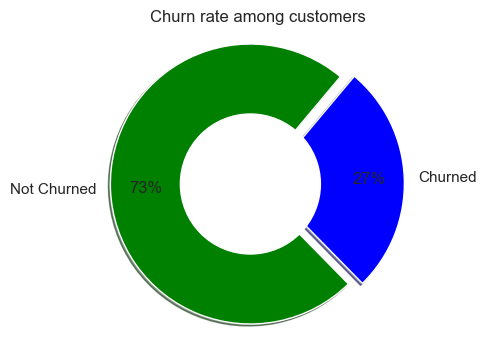

In [1394]:
# visualizing the independent variable churn column
churn_data = training_data['Churn'].value_counts()
# Create a pie chart using pyplot to visulaize churn rate
plt.figure(figsize=(4, 4))
plt.pie(churn_data, labels=['Not Churned','Churned'], colors=['green','Blue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Churn rate among customers')
plt.show()

## Bivariate Analysis

## 1. Gender vs Churn

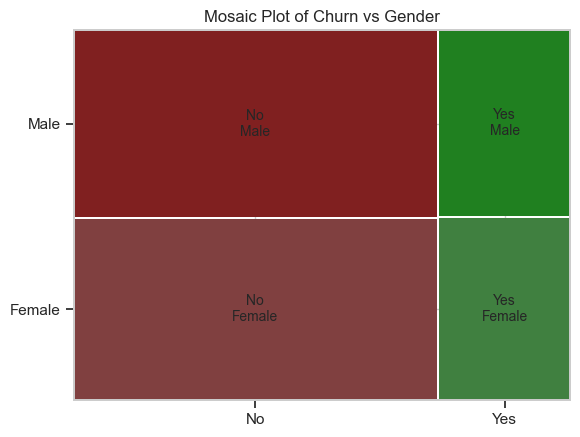

In [1395]:
mosaic(training_data, ['Churn', 'gender'], title='Mosaic Plot of Churn vs Gender')
plt.show()

The churn rate is slightly higher for male customers compared to female customers. This suggests that gender may have a minor influence on customer churn, but it is not a strong determining factor.

## 2. MonthlyCharges vs churn

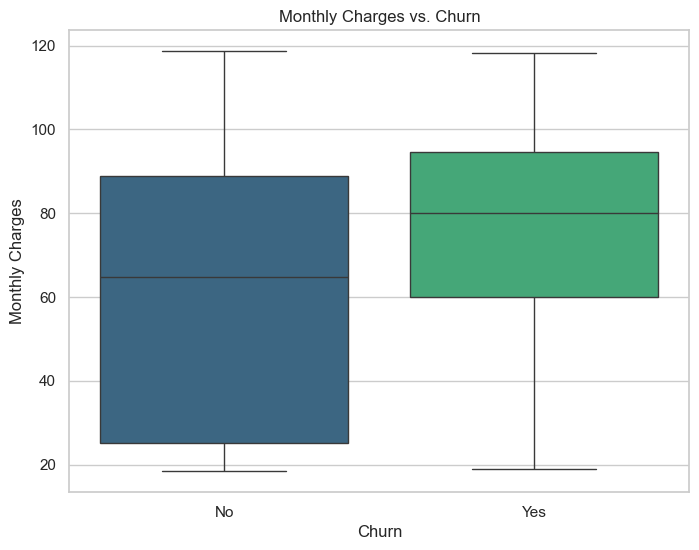

In [1396]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=training_data, palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges vs. Churn')
plt.show()

Churned customers tend to have higher monthly charges compared to non-churned customers.

## 3. Churn Vs Internetservice

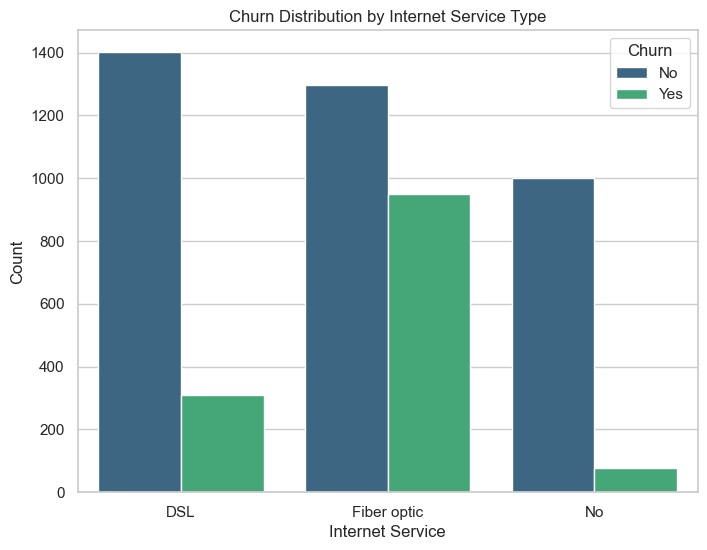

In [1397]:
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=training_data, palette='viridis')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.title('Churn Distribution by Internet Service Type')
plt.legend(title='Churn', loc='upper right')
plt.show()

Customers with fiber optic internet service have a higher churn rate compared to those with DSL or no internet service.

## 4.Churn vs Partner

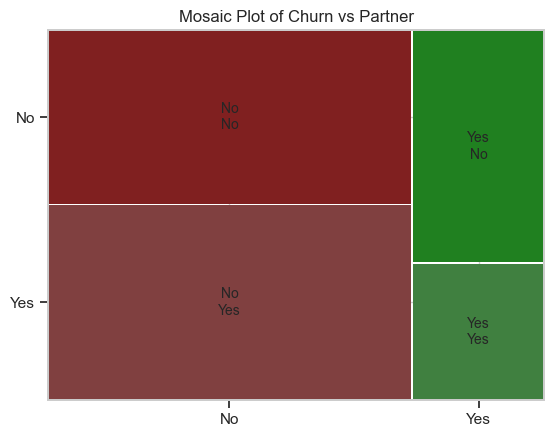

In [1398]:
mosaic(training_data, ['Churn', 'Partner'], title='Mosaic Plot of Churn vs Partner')
plt.show()

Customers with a partner churn less than customers with no partner.

## 5.Tenure vs Churn

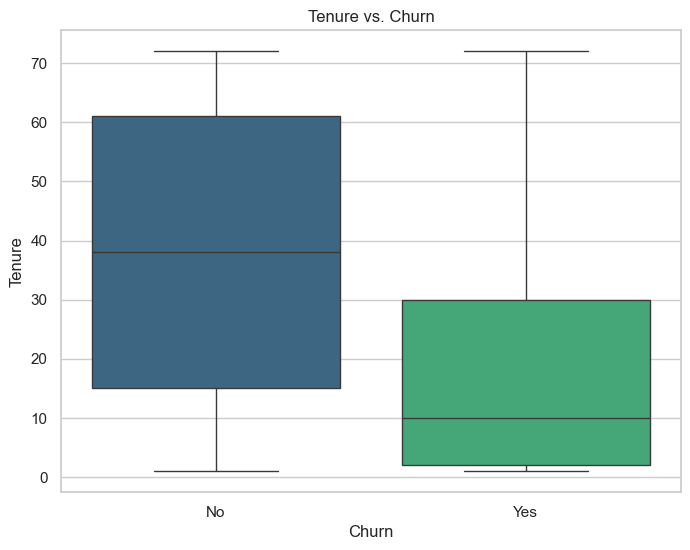

In [1399]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='tenure', data=training_data, palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.title('Tenure vs. Churn')
plt.show()

Customers with lower tenure have a higher churn rate, while those with higher tenure are less likely to churn. There is an inverse relationship between tenure and churn rate.

## Multivariate Analysis

## 1.Relationship between Monthly Charges, Internet Service, and Churn

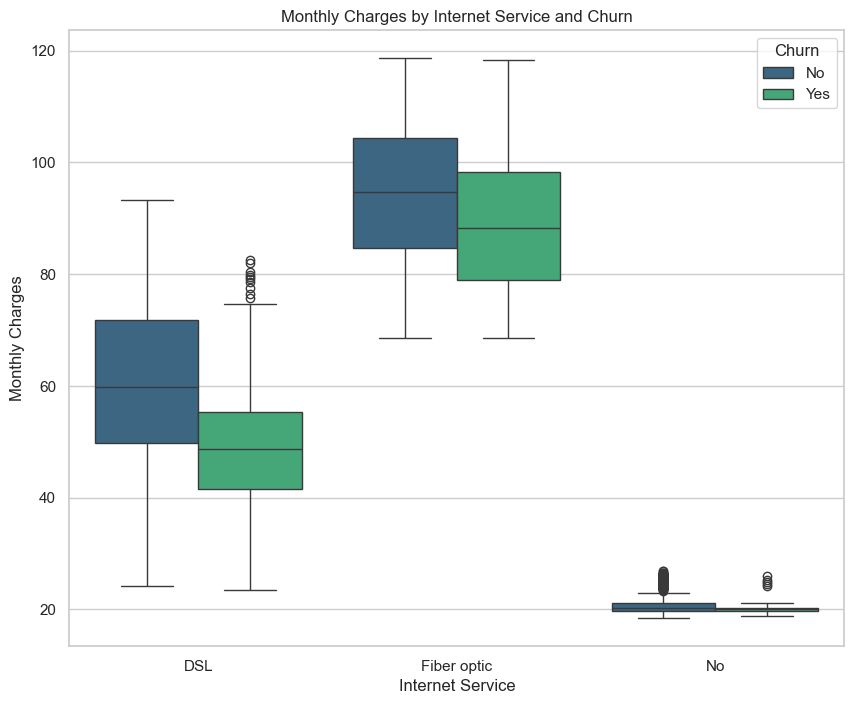

In [1400]:
# Create box plots for numerical features by churn
plt.figure(figsize=(10, 8))
sns.boxplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=training_data, palette='viridis')
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges by Internet Service and Churn')
plt.show()

It can be observed that customers using fiber optic internet service generally have higher monthly charges compared to those using DSL. the boxplot highlights that churned customers, irrespective of the internet service type, tend to have higher monthly charges compared to non-churned customers. This suggests that customers with higher monthly charges may be more likely to churn, and this relationship may be more pronounced for fiber optic users.

## Answering Questions

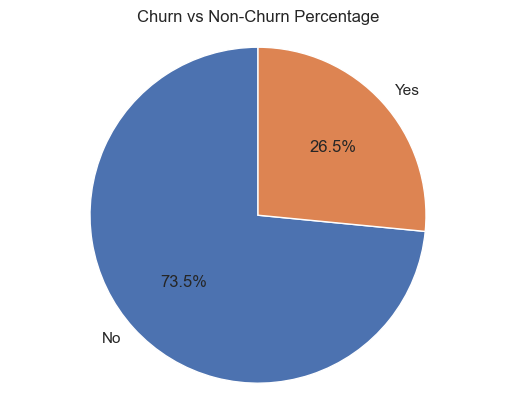

In [1401]:
## 1. What is the total churn rate
def calculate_churn_percentage(df, column_name):
    """
    Calculate the percentage of churn and non-churn in a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - column_name (str): The column name where churn data is stored.
    
    Returns:
    - dict: Dictionary containing the percentage of churn and non-churn.
    """
    # Calculate the frequency of each category in the specified column
    counts = df['Churn'].value_counts(normalize=True)
    
    # Convert the frequencies to percentage
    percentages = counts * 100
    
    return percentages

def plot_churn_pie_chart(percentages):
    """
    Plots a pie chart of churn and non-churn percentages.
    
    Parameters:
    - percentages (pd.Series): Series containing the percentages of churn and non-churn.
    """
    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Title
    plt.title('Churn vs Non-Churn Percentage')

    # Show the plot
    plt.show()

df = pd.DataFrame(training_data)

# Calculate churn and non-churn percentages
churn_percentages = calculate_churn_percentage(df, 'Churn')

# Plot the pie chart
plot_churn_pie_chart(churn_percentages)

## 2. How does the different boolean attribute affect the churn

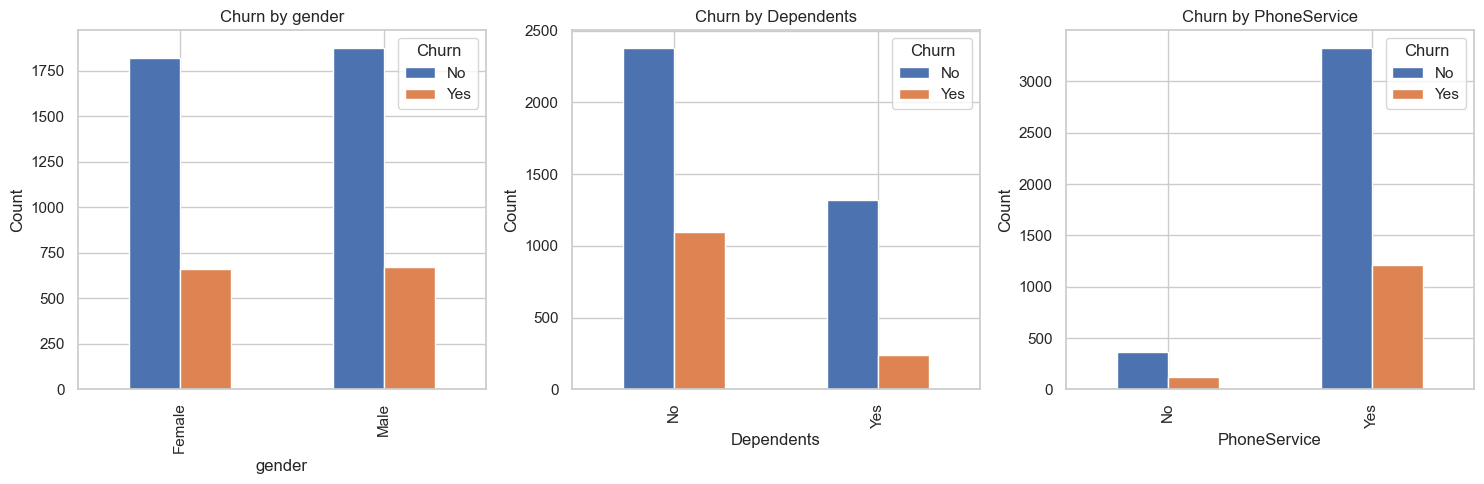

In [1402]:
# How does gender, partner and phone service affect churn
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, feature in zip(axes, ['gender', 'Dependents', 'PhoneService']):
    df.groupby([feature, 'Churn']).size().unstack().plot(kind='bar', ax=ax, title=f'Churn by {feature}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. How does the different non-boolean affect churn e.g Contract,PaymentMethod,

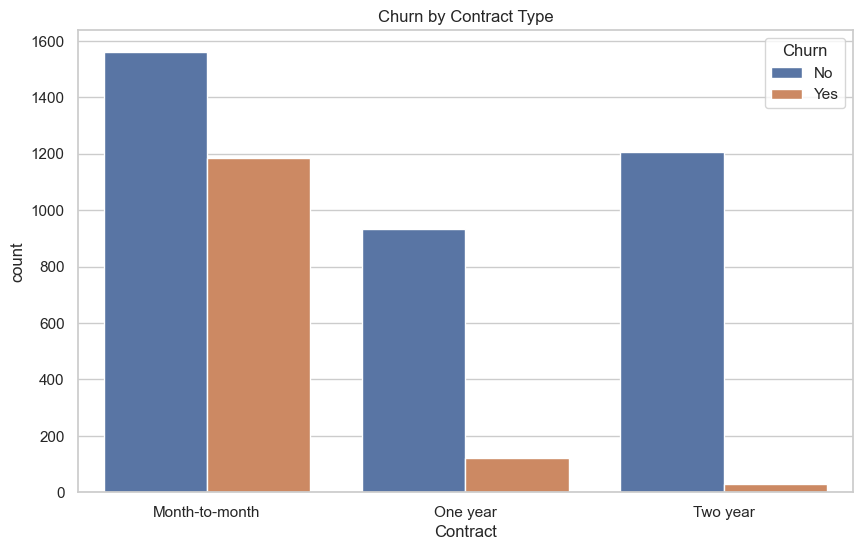

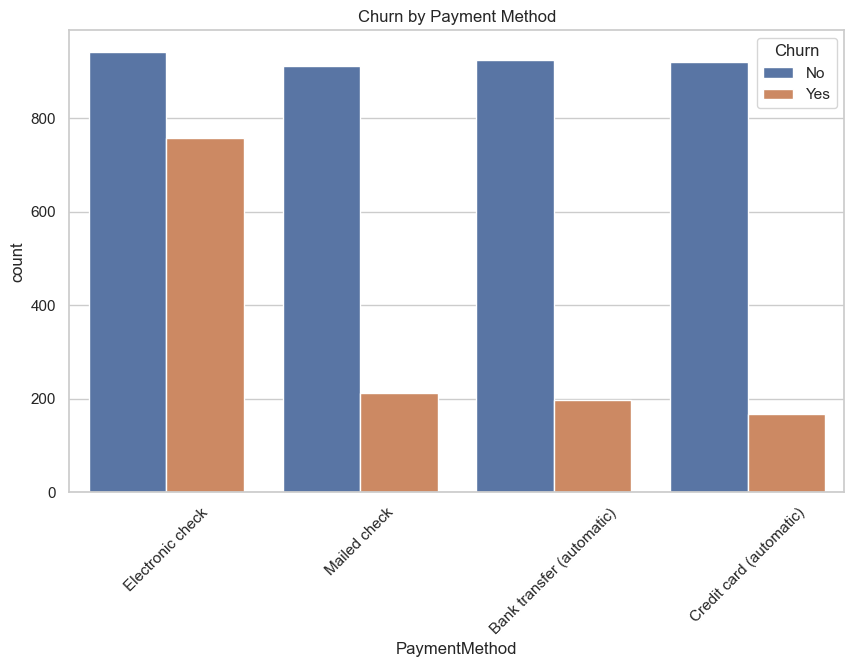

In [1403]:
# Setting up the visualization environment
sns.set(style="whitegrid")

# Bar plot for Contract vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=training_data)
plt.title('Churn by Contract Type')
plt.show()

# Clustered bar plot for Payment Method vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=training_data)
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

## 4 How does monthly charges and total charges affect churn

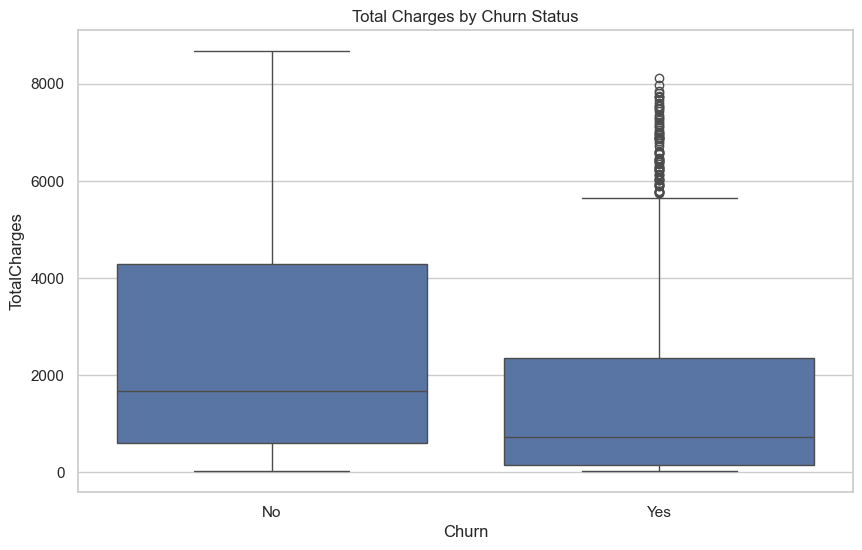

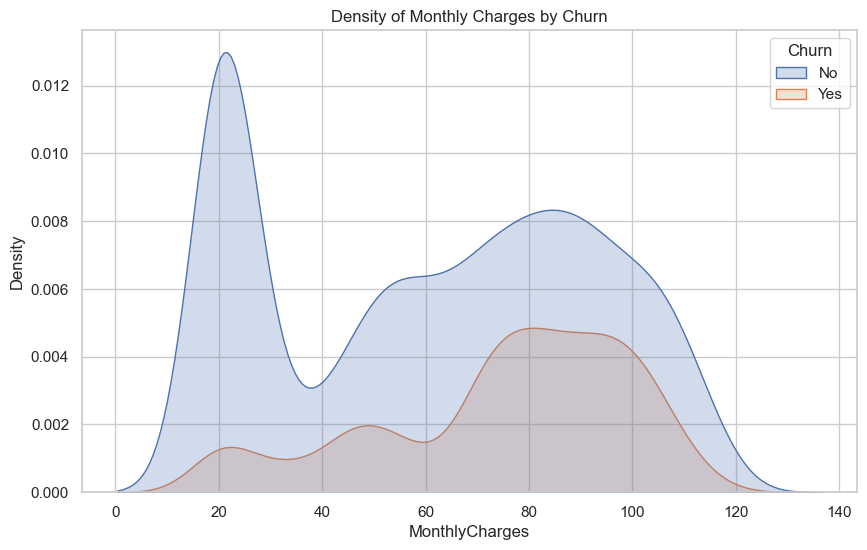

In [1404]:
# Setting up the visualization environment
sns.set(style="whitegrid")


# Box Plot for Total Charges by Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=training_data)
plt.title('Total Charges by Churn Status')
plt.show()

# Density Plot for Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=training_data, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Density of Monthly Charges by Churn')
plt.show()

## 5. How does the type of internet service affect the churn

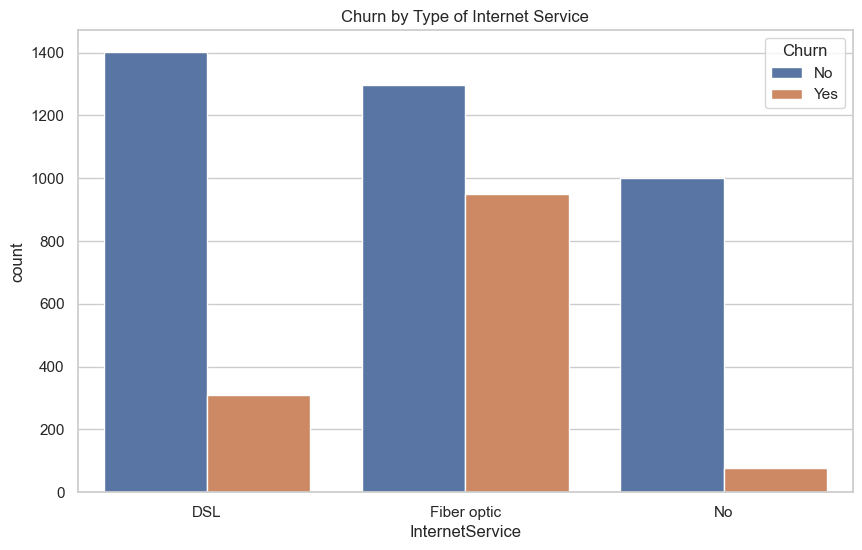

In [1405]:
# Count Plot for Internet Service vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data= training_data)
plt.title('Churn by Type of Internet Service')
plt.show()

In [1406]:
#Lets look at correlation between numeric values and target variable (Churn)
numeric_columns = training_data.select_dtypes(include=['int64', 'float64'])
numeric_columns.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.239642,0.826188
MonthlyCharges,0.239642,1.000000,0.646813
TotalCharges,0.826188,0.646813,1.000000


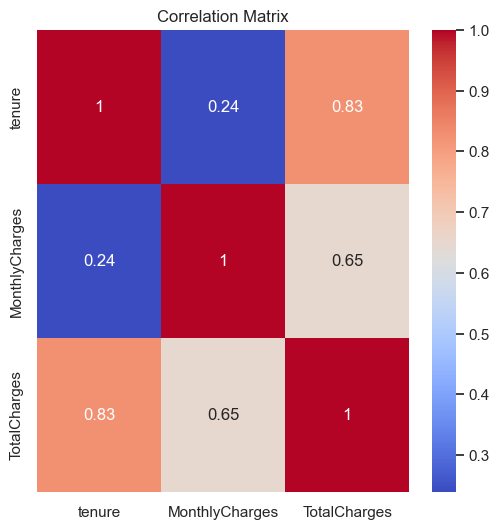

In [1407]:
plt.figure(figsize=(6,6))
sns.heatmap(numeric_columns.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Processing & Engineering

In [1408]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   object 
 2   Partner           5034 non-null   object 
 3   Dependents        5034 non-null   object 
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   object 
 6   MultipleLines     5034 non-null   object 
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 


In [1409]:
training_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


In [1410]:
# check unique values of each column
for column in training_data.columns:
    print('Column: {} - Unique Values: {}'.format(column, training_data[column].unique()))

Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No' 'Yes' 'No phone service']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSupport - Unique Values: ['No' 'Yes' 'No internet service']
Column: StreamingTV - Unique Values: ['No' 'Yes' 'No internet service']

Mutual Information scores

We calculate the mutual scores between categorical features and the target variable (Churn) in the test dataset. Mutual Information is a measure of the dependence between two variables, which quantifies how much knowing the value of one variable reduces uncertainty about the other variable.

This helps identify which categorical features are more informative in relation to the target variable, making them potentially valuable for predicting or understanding the 'Churn' behavior.

In [1411]:
# Lets find out feature dependency on the target variable using mutual information score
x_cat = training_data.select_dtypes(include=object).drop('Churn', axis=1)
y_cat = training_data['Churn']

mi_scores = []

for column in x_cat.columns:
    mi_score = mutual_info_score(x_cat[column], y_cat)
    mi_scores.append((column, mi_score))

mi_scores.sort(key=lambda x: x[1], reverse=True)

for feature, score in mi_scores:
    print(f"Feature: {feature}, Mutual Information Score: {score}")

Feature: Contract, Mutual Information Score: 0.10284790516675524
Feature: InternetService, Mutual Information Score: 0.05944428811167132
Feature: PaymentMethod, Mutual Information Score: 0.04163984913943765
Feature: TechSupport, Mutual Information Score: 0.030007109249305178
Feature: OnlineSecurity, Mutual Information Score: 0.029670157336360276
Feature: PaperlessBilling, Mutual Information Score: 0.019508874345666505
Feature: OnlineBackup, Mutual Information Score: 0.015826778687180174
Feature: Dependents, Mutual Information Score: 0.015615368107435551
Feature: DeviceProtection, Mutual Information Score: 0.013717699147021103
Feature: StreamingMovies, Mutual Information Score: 0.013349078621584257
Feature: SeniorCitizen, Mutual Information Score: 0.010389723457655958
Feature: Partner, Mutual Information Score: 0.010018147440621322
Feature: StreamingTV, Mutual Information Score: 0.009953736504141789
Feature: MultipleLines, Mutual Information Score: 0.0008281912846177519
Feature: PhoneSe

In [1412]:
features = [score[0] for score in mi_scores]
scores = [score[1] for score in mi_scores]

# Create a bar plot using Plotly
fig = px.bar(x=scores, y=features, orientation='h', color=scores,
             labels={'x': 'Mutual Information Score', 'y': 'Features'},
             title='Categorical Features Relationship with Target (Churn)',
             template='plotly',
             color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed